In [30]:
# Installing dependencies
%pip install tensorflow
%pip install -U 'flwr[simulation]'
%pip install -q "flwr-datasets[vision]"
%pip install torch torchvision
%pip install scikit-learn
%pip install numpy==1.24.3
%pip install Pillow


  Using cached numpy-1.26.4-cp312-cp312-macosx_10_9_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-macosx_10_9_x86_64.whl (20.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 14.0 MB/s  0:

In [2]:
from flwr.common import parameters_to_ndarrays, ndarrays_to_parameters
from flwr.common import FitIns, EvaluateIns
from flwr.server.strategy.aggregate import aggregate
import random


class Servidor(fl.server.strategy.FedAvg):
    def __init__(self, num_clients, dirichlet_alpha, fraction_fit=0.2):
        self.num_clients     = num_clients
        self.dirichlet_alpha = dirichlet_alpha

        super().__init__(fraction_fit=fraction_fit, min_available_clients=num_clients)

    def configure_fit(self, server_round, parameters, client_manager):
      """Configure the next round of training."""

      config = {
          'server_round': server_round,
      }
      fit_ins = FitIns(parameters, config)


      sample_size, min_num_clients = self.num_fit_clients(
          client_manager.num_available()
      )
      clients = client_manager.sample(
          num_clients=sample_size, min_num_clients=min_num_clients
      )

      # Return client/config pairs
      print(clients)
      return [(client, fit_ins) for client in clients]

    def aggregate_fit(self, server_round, results, failures):
      parameters_list = []
      
      for _, fit_res in results:
          print(f"Rodada {server_round} resultados de treinamento: {fit_res}")
          parameters = parameters_to_ndarrays(fit_res.parameters)
          exemplos   = int(fit_res.num_examples)

          parameters_list.append([parameters, exemplos])

      agg_parameters = aggregate(parameters_list)
      agg_parameters = ndarrays_to_parameters(agg_parameters)

      return agg_parameters, {}

    def configure_evaluate(self, server_round, parameters, client_manager):
      config = {
          'server_round': server_round,
      }

      evaluate_ins = EvaluateIns(parameters, config)


      sample_size, min_num_clients = self.num_evaluation_clients(
          client_manager.num_available()
      )

      clients = client_manager.sample(
          num_clients=sample_size, min_num_clients=min_num_clients
      )

      return [(client, evaluate_ins) for client in clients]

    def aggregate_evaluate(self, server_round, results, failures):
      accuracies = []

      for _, response in results:
          acc = response.metrics['accuracy']
          accuracies.append(acc)

      avg_acc = sum(accuracies)/len(accuracies)
      print(f"Rodada {server_round} acurácia agregada: {avg_acc}")

      return avg_acc, {}

In [3]:
import tensorflow as tf
import flwr as fl

import warnings
warnings.filterwarnings("ignore")

def create_client(cid):
    client = Cliente(cid, NIID, NCLIENTS, DIRICHLET_ALPHA, ATTACK_TYPE, FILENAME)
    return client.to_client()


class Simulation():
    def __init__(self):
        self.server  = Servidor(num_clients=NCLIENTS, dirichlet_alpha=DIRICHLET_ALPHA, fraction_fit=FRACTION_FIT)

    def run_simulation(self):
        fl.simulation.start_simulation(
            client_fn        = create_client,
            num_clients      = NCLIENTS,
            config           = fl.server.ServerConfig(num_rounds=NROUNDS),
            strategy         = self.server,
            client_resources = {"num_cpus": 12, "num_gpus": 0.0},)

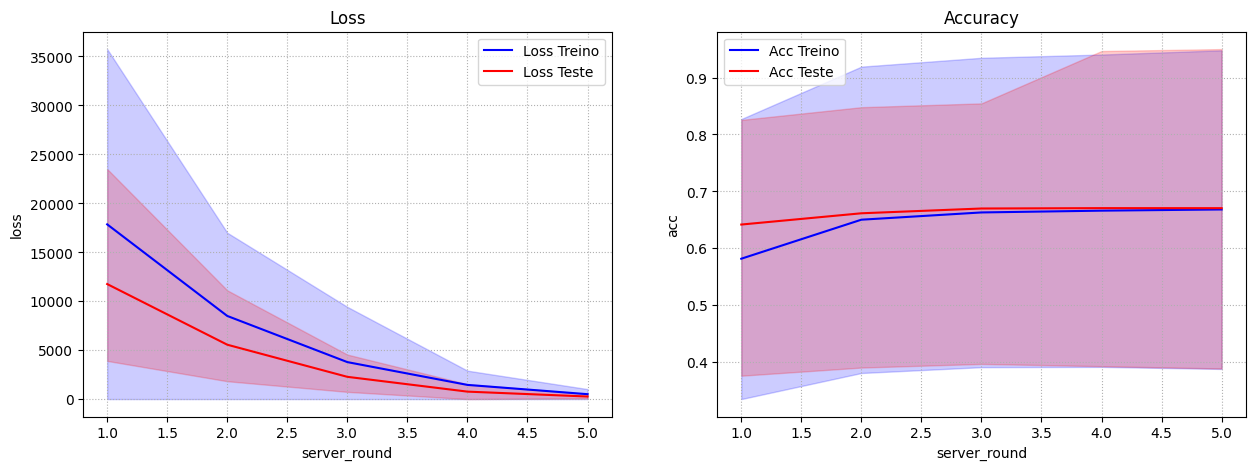

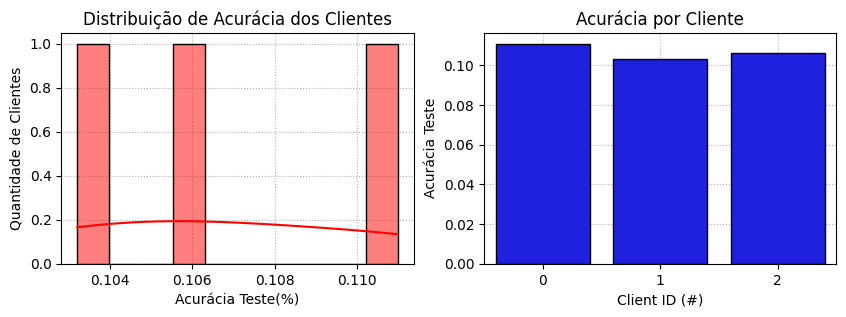

In [8]:
import plot_utils
plot_utils.plot_loss_acc("model_poisoning")
plot_utils.plot_performance_distribution("model_poisoning", NCLIENTS)

In [14]:
def run_ataque(modelo, imagem_fake, label_fake, gradientes_compartilhados,
               optimizer, criterion, ataque='dlg'):
    history     = []
    to_pilimage = transforms.ToPILImage()
    loop = tqdm(range(140), desc=f"🔧 Invertendo Gradientes...",  )
    for iters in loop:
        def closure():
            optimizer.zero_grad()

            pred_ataque = modelo(imagem_fake)

            if ataque == 'dlg':
                onehot_ataque = F.softmax(label_fake, dim=-1)

            elif ataque == 'idlg':
                onehot_ataque = torch.argmin(torch.sum(gradientes_compartilhados[-2],
                                                       dim=-1), dim=-1).detach().reshape((1,)).requires_grad_(False)

            loss_ataque       = criterion(pred_ataque, onehot_ataque)
            gradientes_ataque = torch.autograd.grad(loss_ataque, modelo.parameters(),
                                                    create_graph=True)
            grad_diff = 0

            for gx, gy in zip(gradientes_ataque, gradientes_compartilhados):
                grad_diff += ((gx - gy) ** 2).sum()

            grad_diff.backward()

            return grad_diff

        optimizer.step(closure)
        current_loss = closure().item()
        loop.set_postfix(loss_inversao=current_loss)  # Atualiza a barra de progresso com a loss
        history.append(to_pilimage(imagem_fake[0].cpu()))

    return history

In [20]:
output_modelo    = modelo(imagem)
criterion        = utils.cross_entropy_for_onehot
logits           = criterion(output_modelo, label)
gradientes       = torch.autograd.grad(logits, modelo.parameters())

gradientes_compartilhados = list((_.detach().clone() for _ in gradientes))



In [ ]:
modelo = utils.cria_modelo('cifar10')
utils.poda_modelo(modelo, 0.4)
output_modelo    = modelo(imagem)
criterion        = utils.cross_entropy_for_onehot
logits           = criterion(output_modelo, label)
gradientes       = torch.autograd.grad(logits, modelo.parameters())

gradientes_compartilhados = list((_.detach().clone() for _ in gradientes))